In [1]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"  
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [2]:
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [3]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 38.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=4725a619e02de9512ee47ccb45688c6255a596f5c70066e700185739d9ac028a
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#import packages
from pyspark import SparkContext, SparkConf
import sys
#import os
import time
import csv
from itertools import combinations
import random
import json
import xgboost as xgb
import numpy as np
import pandas as pd
import math
#from sklearn.metrics import mean_squared_error
from datetime import datetime 
#from datetime import date

#initialize Spark Session
#conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "4g").set("spark.driver.memory", "4g")
#sc = SparkContext(conf=conf)

sc = SparkContext('local[*]','HW3-task2_3').getOrCreate()
sc.setLogLevel('WARN')

In [ ]:
start_entire = time.time()

Task 2_2: XGBoost

In [6]:
start = time.time()

#load in review data
reviews_train = sc.textFile('/content/drive/MyDrive/data/yelp_train.csv')
#reviews_train = sc.textFile(sys.argv[1])
reviews_validation = sc.textFile('/content/drive/MyDrive/data/yelp_val_in.csv') #### grading will use yelp_val_in .... so switch later
#reviews_train = sc.textFile(sys.argv[2])
#reviews.take(10)

reviews_train = reviews_train.mapPartitions(lambda x: csv.reader(x))
header_reviews_train = reviews_train.first() #remove headers
reviews_train = reviews_train.filter(lambda x: x != header_reviews_train)
#reviews.take(10)

reviews_validation = reviews_validation.mapPartitions(lambda x: csv.reader(x))
header_reviews_validation = reviews_validation.first() #remove headers
reviews_validation = reviews_validation.filter(lambda x: x != header_reviews_validation)
#reviews.take(10)


#map user_id and business_id to index values (i.e. assign value to each user)
users_train = reviews_train.map(lambda x: x[0]).distinct().collect()
users_validation = reviews_validation.map(lambda x: x[0]).distinct().collect()
#len(users_validation)
users_all = list(set().union(users_train,users_validation)) #get unique users across train and validation
total_users = len(users_all)

business_train = reviews_train.map(lambda x: x[1]).distinct().collect()
business_validation = reviews_validation.map(lambda x: x[1]).distinct().collect()
#len(business_validation)
business_all = list(set().union(business_train,business_validation)) #get unique businesses across train and validation
total_business = len(business_all)

#group users who reviewed each business, map integer indices over string id values
map_users = dict([(users_all[index], index) for index in range(total_users)])
#map_users = {users_all[index]:index for index in range(total_users)} ### another way
map_back_users = dict([(index, users_all[index]) for index in range(total_users)]) #makes integer the key and business id the value

map_business = dict([(business_all[index], index) for index in range(total_business)])
map_back_business = dict([(index, business_all[index]) for index in range(total_business)]) #makes integer the key and business id the value


#make final train and validation sets from review
reviews_train_final = reviews_train.map(lambda x: (x[1], (x[0], float(x[2][0])))) #business id, (user id, score) -- need like this to join to business_json first
#reviews_validation_final = reviews_validation.map(lambda x: (map_business[x[1]], (map_users[x[0]], int(x[2][0]))))
reviews_validation_final = reviews_validation.map(lambda x: (x[1], x[0])) #don't need stars/scores for validation set

reviews_train_final.take(5) #(business id, (user id, score))

[('gTw6PENNGl68ZPUpYWP50A', ('vxR_YV0atFxIxfOnF9uHjQ', 5.0)),
 ('iAuOpYDfOTuzQ6OPpEiGwA', ('o0p-iTC5yTBV5Yab_7es4g', 4.0)),
 ('5j7BnXXvlS69uLVHrY9Upw', ('-qj9ouN0bzMXz1vfEslG-A', 2.0)),
 ('jUYp798M93Mpcjys_TTgsQ', ('E43QxgV87Ij6KxMCHcijKw', 5.0)),
 ('3MntE_HWbNNoyiLGxywjYA', ('T13IBpJITI32a1k41rc-tg', 5.0))]

In [7]:
#get all scores made by users for each business
self_business_scores = reviews_train_final.groupByKey().mapValues(list).collect() # stores business, {user:average score} and {user:original score}
self_business_scores_dict = dict([(self_business_scores[index][0], dict(self_business_scores[index][1])) for index in range(len(self_business_scores))]) # stores (business, user:original score)

#get all scores each user made for a business
user_rated_scores = reviews_train_final.map(lambda x: (x[1][0], (x[0],x[1][1]))).groupByKey().mapValues(list).collect() # stores user, list of (business, score)
user_rated_scores_dict = dict([(user_rated_scores[index][0], user_rated_scores[index][1]) for index in range(len(user_rated_scores))]) # converts above to a dict

#computes the average score across all users in train set
global_user_average= np.mean(reviews_train_final.map(lambda x: x[1][1]).collect())

In [ ]:
#if we ever want to use attributes from business data
#wtf = business_json.map(lambda x: (x['business_id'], x['attributes'])).collect()
#wtf_df = pd.DataFrame(wtf, columns=['business_id','attributes'])
#df2 = pd.json_normalize(wtf_df['attributes'])
#finaldf.replace({'False': 0, 'True': 1}, inplace=True)
#finaldf.loc[( pd.isnull(finaldf['BikeParking']) ),'BikeParking'] = 0
#finaldf['BusinessAcceptsCreditCards'].fillna(value=0, inplace=True)
#finaldf = pd.concat([wtf_df.drop(['attributes'], axis=1), df2], axis=1)


In [8]:
#load in additional data #################try adding 1-2 more features for competition
business_json = sc.textFile('/content/drive/MyDrive/data/business.json').map(lambda x: json.loads(x))
checkin = sc.textFile('/content/drive/MyDrive/data/checkin.json').map(lambda x: json.loads(x))
photo = sc.textFile('/content/drive/MyDrive/data/photo.json').map(lambda x: json.loads(x))
tip = sc.textFile('/content/drive/MyDrive/data/tip.json').map(lambda x: json.loads(x)) #for competition, maybe do NLP on comments/text
user_json = sc.textFile('/content/drive/MyDrive/data/user.json').map(lambda x: json.loads(x))

In [9]:
#load in additional data #################try adding 1-2 more features for competition
business_json = sc.textFile('/content/drive/MyDrive/data/business.json').map(lambda x: json.loads(x))
checkin = sc.textFile('/content/drive/MyDrive/data/checkin.json').map(lambda x: json.loads(x))
photo = sc.textFile('/content/drive/MyDrive/data/photo.json').map(lambda x: json.loads(x))
tip = sc.textFile('/content/drive/MyDrive/data/tip.json').map(lambda x: json.loads(x)) #for competition, maybe do NLP on comments/text
user_json = sc.textFile('/content/drive/MyDrive/data/user.json').map(lambda x: json.loads(x))

#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful']))) #x['friends'].count(',')+1
#user_json_feat = user_json.map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful']))) # x['fans']

#business_json.take(5) #maybe ask how can i grab the attributes dictionary values
user_json.take(5) #maybe use cool/fans/funny/useful


#join selected features to train data
#reviews_train_final: business id, (user id, score)
train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], x[0], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][0][1])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score


train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','score'])


#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
#train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][1], x[1][1][2])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful


validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
#validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df.head()

,business_id,user_id,business_stars,business_review_count,user_average_stars,user_review_count,useful
66678,-ErwgUmZ1-jHW_rSu55jlg,---1lKK3aKOuomHnwAkAow,4.0,32,3.96,252,67
66677,1JgaRBX0oiRsvEhHF3ZMjw,---1lKK3aKOuomHnwAkAow,4.0,59,3.96,252,67
66669,DXlDzOcpdUE_F21tok0fgw,---1lKK3aKOuomHnwAkAow,4.0,1830,3.96,252,67
66672,Ks0M3J4vZAKsHPuCINz5fQ,---1lKK3aKOuomHnwAkAow,3.5,296,3.96,252,67
66667,N8Rwk4XrKaHYXXninuxg9Q,---1lKK3aKOuomHnwAkAow,5.0,66,3.96,252,67


In [ ]:
#calculate standard deviation or mean of each user's and business' score
#user_mean = dict()
#for key, values in list(user_rated_scores_dict.items())[0:]:
  #scores = list()
  #for i in values:
    #scores.append(i[1])
  #user_mean[key] = (np.mean(scores), np.std(scores))
##user_mean_df = pd.DataFrame(user_mean.items(), columns = ['user_id','user_mean'])
#user_mean_df = pd.DataFrame(user_mean).T
#user_mean_df=user_mean_df.reset_index()
#user_mean_df.columns = ['user_id','user_mean', 'user_std']

#business_mean = dict()
#for key, values in list(self_business_scores_dict.items())[0:]:
  #scores = list()
  #for val in values.values():
    #scores.append(val)
  #business_mean[key] = np.mean(scores)

#business_mean_df = pd.DataFrame(business_mean.items(), columns = ['business_id','business_mean'])

#train_feat_df2 = train_feat_df.merge(user_mean_df, how='left', on='user_id')
#train_feat_df2 = train_feat_df2.merge(business_mean_df, how='left', on='business_id')
#train_feat_df2['user_mean'].fillna(value=train_feat_df2['user_mean'].mean(), inplace=True)
#train_feat_df2['business_mean'].fillna(value=train_feat_df2['business_mean'].mean(), inplace=True)

##train_feat_df2.head()

#validation_feat_df2 = validation_feat_df.merge(user_mean_df, how='left', on='user_id')
#validation_feat_df2 = validation_feat_df2.merge(business_mean_df, how='left', on='business_id')
#validation_feat_df2['user_mean'].fillna(value=validation_feat_df2['user_mean'].mean(), inplace=True)
#validation_feat_df2['business_mean'].fillna(value=validation_feat_df2['business_mean'].mean(), inplace=True)

##validation_feat_df2.head()

In [ ]:
#train_feat_df2 = train_feat_df.copy()
#train_feat_df2.loc[( (train_feat_df2['score'] <=2) ),'business_stars'] = (0.8*train_feat_df2['business_stars'])
#train_feat_df2.loc[( (train_feat_df2['score'] <=2) ),'user_average_stars'] = (0.8*train_feat_df2['user_average_stars'])
##train_feat_df2[train_feat_df2['score'] <= 2]

In [ ]:
#train_feat_df2 = train_feat_df.copy()
#train_feat_df2['user_average_stars'] = ((train_feat_df2['user_review_count']*train_feat_df2['user_average_stars'])-train_feat_df2['business_stars'])/(train_feat_df2['user_review_count']-1)

#validation_feat_df2 = validation_feat_df.copy()
#validation_feat_df2['user_average_stars'] = ((validation_feat_df2['user_review_count']*validation_feat_df2['user_average_stars'])-validation_feat_df2['business_stars'])/(validation_feat_df2['user_review_count']-1)

#train_feat_df2.head()
#validation_feat_df2.head()

In [16]:
#separate into train, test (validation) sets for modeling
X_train = train_feat_df.drop(['business_id','user_id','score'], axis=1)
#X_train = np.array(X_train)
#xgb_train = xgb.DMatrix(X_train, label = y_train)

y_train = train_feat_df['score']
#y_train = np.array(y_train)

X_test = validation_feat_df.drop(['business_id','user_id',], axis=1)
#X_test = np.array(X_test)
#xgb_test = xgb.DMatrix(X_test)


#train xgboost model
xgb_mod = xgb.XGBRegressor(n_estimators=500, max_depth=5, random_state=100) ########## objective="reg:squarederror"
xgb_mod.fit(X_train, y_train)

y_pred = xgb_mod.predict(X_test)

##update predictions so that if pred is <1, set to 1, and if pred >5, set to 5
y_pred2 = y_pred.copy()
y_pred2[y_pred2 < 1] = 1
y_pred2[y_pred2 > 5] = 5

#save results
xgboost_pred = reviews_validation.map(lambda x: [x[0], x[1]])
#xgboost_pred = xgboost_pred.collect()
xgboost_pred = xgboost_pred.sortBy(lambda x: (x[0],x[1])).collect() #need to sort by user id, business id to match X_train order
for i in range(len(xgboost_pred)):
  xgboost_pred[i].append(float(y_pred2[i]))

with open('./results_task2_2.csv', 'w') as fp:
  fp.write('user_id, business_id, prediction\n') #add headers
  for row in xgboost_pred:
    fp.write(f'{row[0]},{row[1]},{row[2]}\n') ########change row[2] to float(row[2]) if error in submission

end = time.time()
print(f'Duration: {end-start}')

[05:07:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Duration: 798.7783784866333


In [17]:
######to compare results to ground truth

#predicted = list()
#with open('results_new.csv') as fp:
    #pred = csv.reader(fp)
    #for pair in list(pred)[1:]:
        #predicted.append((pair[0], pair[1], pair[2]))
#predicted = sorted(predicted, key = lambda x: (x[0],x[1]))
predicted = list()
for i in range(len(xgboost_pred)):
    predicted.append((xgboost_pred[i][0], xgboost_pred[i][1], float(xgboost_pred[i][2])))

actual = list()
with open('/content/drive/MyDrive/data/yelp_val.csv') as fp:
    act = csv.reader(fp)
    for pair in list(act)[1:]:
        actual.append((pair[0], pair[1], pair[2]))
actual = sorted(actual, key = lambda x: (x[0],x[1])) #sort by user id, business id to match val_set

differences = list()
for i in range(len(predicted)):
    differences.append((float(predicted[i][2]) - float(actual[i][2]))**2)
print(f'RMSE: {math.sqrt(sum(differences)/len(predicted))}')

############### to store the difference margin (for competition)
diff_margin = {"<1": 0, "1~2": 0, "2~3": 0, "3~4": 0, "4~5": 0}
for i in range(len(differences)):
  if abs(differences[i]) < 1:
    diff_margin["<1"] = diff_margin.get("<1") + 1
  elif 1 <= abs(differences[i]) < 2:
    diff_margin["1~2"] = diff_margin.get("1~2") + 1
  elif 2 <= abs(differences[i]) < 3:
    diff_margin["2~3"] = diff_margin.get("2~3") + 1
  elif 3 <= abs(differences[i]) < 4:
    diff_margin["3~4"] = diff_margin.get("3~4") + 1
  else:
    diff_margin["4~5"] = diff_margin.get("4~5") + 1

RMSE: 0.9808103134459722


In [18]:
diff_margin

{'1~2': 20913, '2~3': 8032, '3~4': 4243, '4~5': 7000, '<1': 101856}

In [ ]:
#####validation data not contained in review_train.json
#reviews = sc.textFile('/content/drive/MyDrive/data/review_train.json').map(lambda x: json.loads(x))
#reviews_feat = reviews.filter(lambda x: x["user_id"] in map_users).map(lambda x: ( (x["business_id"],x["user_id"]), len(x['text'])))

#train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
#train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
#train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
#train_feat = train_feat.map(lambda x: ((x[1][0][0], x[0]), x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][0][1]))
#train_feat.leftOuterJoin(reviews_feat).take(5)

In [ ]:
######## maybe save grid search for competition/hybrid model
from sklearn.model_selection import GridSearchCV

alphas = [0.01, 0.1, 1, 10] #10**np.linspace(2,-2,10)

xgb_mod = xgb.XGBRegressor(n_estimators=40, max_depth=5, objective="reg:squarederror")

#can use grid search cv with xgboost
param = {'reg_alpha': alphas} #L1-penalty
grid_search = GridSearchCV(estimator=xgb_mod, param_grid=param, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_.get('reg_alpha')
#best_alpha

xgb_mod2 = xgb.XGBRegressor(n_estimators=40, max_depth=5, alpha=best_alpha, objective='reg:squarederror')

xgb_mod2.fit(X_train,y_train)
y_pred2 = xgb_mod2.predict(X_test)
###########

Task 2_1: Item-based CF

In [19]:
def itemCF(review_data):
  #set reused values
    input_user = review_data[1]
    input_business = review_data[0]
    #return_input = (map_back_users[input_user], map_back_business[input_business])
    return_input = (input_user, input_business)

    pearsonweight_and_originalscore = list() #store the Pearson weight (w_i,n) and corresponding original score (r_u,n)
    #pearsonweight_dict = dict() #keep track of which matched businesses have been calculated

    #cover special cases first
    #if the user has no history, use the average score from all users
    user_history = user_rated_scores_dict.get(input_user, 'NA')
    if user_history == 'NA':
      return tuple(list(return_input) + [global_user_average,0])
    user_average = np.mean([user_score[1] for user_score in user_history])

    #if the business has no ratings, use the average score from the input user
    business_history_self = self_business_scores_dict.get(input_business, 'NA')
    if business_history_self == 'NA':
      return tuple(list(return_input) + [user_average,0])

    else:
      #calculate centered (original-avg) score for users in a business
      business_average = np.mean([*business_history_self.values()]) #get the mean of the input test data business from all the users
      #business_history_centered = {user_id: (float(business_history_self.get(user_id)) - business_average) for user_id in business_history_self}

  #go through each business rated by the user
    for rated_business in user_history:
      rated_business_id = rated_business[0]
      rated_business_score = rated_business[1]

      #get the original and centered scores for the rated business
      near_business_self = self_business_scores_dict.get(rated_business_id)
      #near_business_avg = np.mean([*near_business_self.values()])
      #near_business_centered = {user_id: (float(near_business_self.get(user_id)) - near_business_avg) for user_id in near_business_self}

      #get the users who rated both businesses
      #co_users = set(list(business_history_self.keys())).intersection(set(list(near_business_self.keys())))
      co_users = business_history_self.keys() & near_business_self.keys() #intersection
      if not co_users or len(co_users) < 10: #len(co_users) == 0: #if no user both rated the same businesses, use the average score from the input business
        return tuple(list(return_input) + [np.mean([user_average,business_average]),0])

      #compute co-rated items
      business_history_self2 = {k: business_history_self[k] for k in co_users}
      business_average2 = np.mean([*business_history_self2.values()]) #get the mean of the input test data business from all the users\
      business_history_centered = {user_id: (float(business_history_self2.get(user_id)) - business_average2) for user_id in business_history_self2}
      near_business_self2 = {k: near_business_self[k] for k in co_users}
      near_business_avg = np.mean([*near_business_self2.values()])
      near_business_centered = {user_id: (float(near_business_self2.get(user_id)) - near_business_avg) for user_id in near_business_self2}

      #match = (rated_business_id, input_business)
      #if tuple(sorted(match)) not in pearsonweight_dict: #compute Pearson Correlation weights if it has not been computed already for the matching pair
      pearsonweight_numerator = list() #(r_u,i-r_ibar)(r_u,j-r_jbar)
      business_history_denominator = list() #sqrt((r_u,i-r_ibar)^2))
      near_business_denominator = list() #sqrt((r_u,j-r_jbar)^2)
      for user in co_users: #get the weight for each co-user
        pearsonweight_numerator = pearsonweight_numerator + [business_history_centered.get(user)*near_business_centered.get(user)]
        business_history_denominator = business_history_denominator + [business_history_centered.get(user)**2]
        near_business_denominator = near_business_denominator + [near_business_centered.get(user)**2]

      if (math.sqrt(sum(business_history_denominator)))*(math.sqrt(sum(near_business_denominator))) != 0:
        pearson_weight = sum(pearsonweight_numerator) / (math.sqrt(sum(business_history_denominator))*math.sqrt(sum(near_business_denominator)))
        pearsonweight_and_originalscore = pearsonweight_and_originalscore + [(pearson_weight,rated_business_score)]
        #pearsonweight_dict[match] = pearson_weight

      else: #if the denominator of the weight is 0, no need to compute the weight at all
        pearsonweight_and_originalscore = pearsonweight_and_originalscore + [(0,rated_business_score)]
        #pearsonweight_dict[match] = 0
        #continue

    #sort the weights and keep the highest 7 (|N|=7)
    pearsonweight_and_originalscore.sort(reverse=True, key=lambda x: x[0]) #descending order
    #most_similar_businesses = pearsonweight_and_originalscore[:7]

    pearsonsimilarity_numerator = list() #(r_u,n*w_i,n)
    pearsonsimilarity_denominator = list() #|w_i,n|
    for business in pearsonweight_and_originalscore[:7]: #increasing the size seems to improve results...
      pearsonsimilarity_numerator = pearsonsimilarity_numerator + [business[0]*business[1]]
      pearsonsimilarity_denominator = pearsonsimilarity_denominator + [math.fabs(business[0])]
    
    if sum(pearsonsimilarity_denominator) != 0:
      pearson_similarity = sum(pearsonsimilarity_numerator)/sum(pearsonsimilarity_denominator)
    else: #for safety, if Pearson similarity denominator is 0, then use the average score from the input business
      return tuple(list(return_input) + [np.mean([user_average,business_average]),len(co_users)])

    #if pearson_similarity <= 0: #do not want <=0 scores, so set to the average score from the input business
      #print(return_input)
      #return tuple(list(return_input) + [business_average])
      ##return tuple(list(return_input) + [np.mean([user_average,business_average])]) #experiment with this maybe

    return tuple(list(return_input) + [pearson_similarity,len(co_users)])

In [20]:
start = time.time()

##load in review data
#reviews_train = sc.textFile('/content/drive/MyDrive/data/yelp_train.csv')
##reviews_train = sc.textFile(sys.argv[1])
#reviews_validation = sc.textFile('/content/drive/MyDrive/data/yelp_val_in.csv') #grading will use yelp_val_in... not yelp_val
##reviews_train = sc.textFile(sys.argv[2])

#reviews_train = reviews_train.mapPartitions(lambda x: csv.reader(x))
#header_reviews_train = reviews_train.first() #remove headers
#reviews_train = reviews_train.filter(lambda x: x != header_reviews_train)
##reviews_train.take(10)

#reviews_validation = reviews_validation.mapPartitions(lambda x: csv.reader(x))
#header_reviews_validation = reviews_validation.first() #remove headers
#reviews_validation = reviews_validation.filter(lambda x: x != header_reviews_validation)
##reviews_validation.take(10)


##map user_id and business_id to index values (i.e. assign value to each user)
#users_train = reviews_train.map(lambda x: x[0]).distinct().collect()
#users_validation = reviews_validation.map(lambda x: x[0]).distinct().collect()
##len(users_validation)
#users_all = list(set().union(users_train,users_validation)) #get unique users across train and validation
#total_users = len(users_all)

#business_train = reviews_train.map(lambda x: x[1]).distinct().collect()
#business_validation = reviews_validation.map(lambda x: x[1]).distinct().collect()
##len(business_validation)
#business_all = list(set().union(business_train,business_validation)) #get unique businesses across train and validation
#total_business = len(business_all)

##group users who reviewed each business, map integer indices over string id values
#map_users = dict([(users_all[index], index) for index in range(total_users)])
#map_back_users = dict([(index, users_all[index]) for index in range(total_users)]) #makes integer the key and business id the value

#map_business = dict([(business_all[index], index) for index in range(total_business)])
#map_back_business = dict([(index, business_all[index]) for index in range(total_business)]) #makes integer the key and business id the value


##input mapping in review data
##reviews_train_final = reviews_train.map(lambda x: (map_business[x[1]], (map_users[x[0]], float(x[2][0])))) #business id, (user id, score) -- need like this to join to business_json first
#reviews_train_final = reviews_train.map(lambda x: (x[1], (x[0], float(x[2][0])))) #business id, (user id, score)
##reviews_validation_final = reviews_validation.map(lambda x: (map_business[x[1]], map_users[x[0]])) #don't need stars/scores for validation set
#reviews_validation_final = reviews_validation.map(lambda x: (x[1], x[0])) #don't need stars/scores for validation set

#reviews_train_final.take(5) #(business id, (user id, score))

In [ ]:
##get all scores made by users for each business
#self_business_scores = reviews_train_final.groupByKey().mapValues(list).collect() # stores business, {user:average score} and {user:original score}
#self_business_scores_dict = dict([(self_business_scores[index][0], dict(self_business_scores[index][1])) for index in range(len(self_business_scores))]) # stores (business, user:original score)

##get all scores each user made for a business
#user_rated_scores = reviews_train_final.map(lambda x: (x[1][0], (x[0],x[1][1]))).groupByKey().mapValues(list).collect() # stores user, list of (business, score)
#user_rated_scores_dict = dict([(user_rated_scores[index][0], user_rated_scores[index][1]) for index in range(len(user_rated_scores))]) # converts above to a dict

##computes the average score across all users in train set
#global_user_average= np.mean(reviews_train_final.map(lambda x: x[1][1]).collect())

In [21]:
itemCF_pred = reviews_validation_final.map(lambda x: itemCF(x))
#itemCF_pred = itemCF_pred.collect()
itemCF_pred = itemCF_pred.sortBy(lambda x: (x[0],x[1])).collect() #use this if want to compare to task 2_2 results

In [22]:
with open('./results_task2_1.csv', 'w') as fp:
  fp.write('user_id, business_id, prediction\n') #add headers
  for row in itemCF_pred:
    fp.write(f'{row[0]},{row[1]},{row[2]}\n') ########change row[2] to float(row[2]) if error in submission

end = time.time()
print(f"Duration: {end - start}")


######to compare results to ground truth

#predicted = list()
#with open('results_new.csv') as fp:
    #pred = csv.reader(fp)
    #for pair in list(pred)[1:]:
        #predicted.append((pair[0], pair[1], pair[2]))
#predicted = sorted(predicted, key = lambda x: (x[0],x[1]))
predicted = list()
for i in range(len(itemCF_pred)):
    predicted.append((itemCF_pred[i][0], itemCF_pred[i][1], float(itemCF_pred[i][2])))


actual = list()
with open('/content/drive/MyDrive/data/yelp_val.csv') as fp:
    act = csv.reader(fp)
    for pair in list(act)[1:]:
        actual.append((pair[0], pair[1], pair[2]))
actual = sorted(actual, key = lambda x: (x[0],x[1])) #sort by user id, business id to match val_set... use this if want to compare to task 2_2 results

differences = list()
for i in range(len(predicted)):
    differences.append((float(predicted[i][2]) - float(actual[i][2]))**2)
print(f'RMSE: {math.sqrt(sum(differences)/len(predicted))}')


############### to store the difference margin (for competition)
diff_margin = {"<1": 0, "1~2": 0, "2~3": 0, "3~4": 0, "4~5": 0}
for i in range(len(differences)):
  if abs(differences[i]) < 1:
    diff_margin["<1"] = diff_margin.get("<1") + 1
  elif 1 <= abs(differences[i]) < 2:
    diff_margin["1~2"] = diff_margin.get("1~2") + 1
  elif 2 <= abs(differences[i]) < 3:
    diff_margin["2~3"] = diff_margin.get("2~3") + 1
  elif 3 <= abs(differences[i]) < 4:
    diff_margin["3~4"] = diff_margin.get("3~4") + 1
  else:
    diff_margin["4~5"] = diff_margin.get("4~5") + 1

Duration: 57.28445315361023
RMSE: 1.0191399968702215


In [23]:
diff_margin

{'1~2': 24620, '2~3': 8934, '3~4': 3897, '4~5': 7683, '<1': 96910}

In [ ]:
RMSE: 1.0199739745170648

In [ ]:
end_entire = time.time()
print(f"Duration: {end_entire - start_entire}")


In [ ]:
#check mean and standard deviation
prediction = np.array([float(gg[2]) for gg in predicted])
print("Predicted mean: " + str(prediction.mean()))
print("Predicted std:" + str(prediction.std()))
ground = np.array([float(gg[2]) for gg in actual])
print("Actual mean: "+str(ground.mean()))
print("Actual std: "+str(ground.std()))

In [ ]:
itemCF_pred[0:5]

[('---1lKK3aKOuomHnwAkAow', '-ErwgUmZ1-jHW_rSu55jlg', 3.702991452991453, 0),
 ('---1lKK3aKOuomHnwAkAow', '1JgaRBX0oiRsvEhHF3ZMjw', 3.668269230769231, 0),
 ('---1lKK3aKOuomHnwAkAow', 'DXlDzOcpdUE_F21tok0fgw', 4.087734404898584, 0),
 ('---1lKK3aKOuomHnwAkAow', 'Ks0M3J4vZAKsHPuCINz5fQ', 3.7356711915535445, 0),
 ('---1lKK3aKOuomHnwAkAow', 'N8Rwk4XrKaHYXXninuxg9Q', 4.480769230769231, 0)]

In [ ]:
xgboost_pred[0:5]

Task 2_3: Hybrid Approach

In [ ]:
####next try doing rules for review_count > 5 and co-users/neighbors < 5, etc.
#return_input = (input_user, input_business, len(co_users))

In [24]:
#make dataframes for the predictions
itemCF_pred_df = pd.DataFrame(itemCF_pred, columns = ['user_id', 'business_id', 'prediction_itemCF', 'co-users'])
xgboost_pred_df = pd.DataFrame(xgboost_pred, columns = ['user_id', 'business_id', 'prediction_XGBoost'])

In [25]:
itemCF_pred_df.head()

,user_id,business_id,prediction_itemCF,co-users
0,---1lKK3aKOuomHnwAkAow,-ErwgUmZ1-jHW_rSu55jlg,3.702991,0
1,---1lKK3aKOuomHnwAkAow,1JgaRBX0oiRsvEhHF3ZMjw,3.668269,0
2,---1lKK3aKOuomHnwAkAow,DXlDzOcpdUE_F21tok0fgw,4.087734,0
3,---1lKK3aKOuomHnwAkAow,Ks0M3J4vZAKsHPuCINz5fQ,3.735671,0
4,---1lKK3aKOuomHnwAkAow,N8Rwk4XrKaHYXXninuxg9Q,4.480769,0


In [26]:
xgboost_pred_df.head()

,user_id,business_id,prediction_XGBoost
0,---1lKK3aKOuomHnwAkAow,-ErwgUmZ1-jHW_rSu55jlg,4.173551
1,---1lKK3aKOuomHnwAkAow,1JgaRBX0oiRsvEhHF3ZMjw,4.133530
2,---1lKK3aKOuomHnwAkAow,DXlDzOcpdUE_F21tok0fgw,4.331721
3,---1lKK3aKOuomHnwAkAow,Ks0M3J4vZAKsHPuCINz5fQ,3.761045
4,---1lKK3aKOuomHnwAkAow,N8Rwk4XrKaHYXXninuxg9Q,4.860306


In [35]:
combined_pred_df = itemCF_pred_df.copy()
combined_pred_df['prediction_XGBoost'] = xgboost_pred_df['prediction_XGBoost']
combined_pred_df['business_review_count'] = validation_feat_df['business_review_count']
#combined_pred_df['business_stars'] = validation_feat_df['business_stars']
#combined_pred_df['user_review_count'] = validation_feat_df['user_review_count']
#combined_pred_df['user_average_stars'] = validation_feat_df['user_average_stars']

#combined_pred_df.head()

#can write if-else rules to decide on weights of each prediction here
combined_pred_df['prediction'] = 0
combined_pred_df['prediction'] = (0.1*combined_pred_df['prediction_itemCF'])+(0.9*combined_pred_df['prediction_XGBoost'])
#combined_pred_df.loc[( (combined_pred_df['co-users'] < 100) ),'prediction'] = combined_pred_df['prediction_XGBoost']
#combined_pred_df.loc[( (combined_pred_df['co-users'] >0) ),'prediction'] = combined_pred_df['prediction_itemCF']
#combined_pred_df.loc[( (combined_pred_df['business_review_count'] >= 100) ),'prediction'] = (0.1*combined_pred_df['prediction_itemCF'])+(0.9*combined_pred_df['prediction_XGBoost'])

#combined_pred_df.loc[( (combined_pred_df['prediction'] <= 2.75) & (combined_pred_df['prediction'] >= 2.5) ),'prediction'] = 2
combined_pred_df.head()

,user_id,business_id,prediction_itemCF,co-users,prediction_XGBoost,business_review_count,prediction
0,---1lKK3aKOuomHnwAkAow,-ErwgUmZ1-jHW_rSu55jlg,3.702991,0,4.173551,1589,4.126495
1,---1lKK3aKOuomHnwAkAow,1JgaRBX0oiRsvEhHF3ZMjw,3.668269,0,4.133530,1589,4.087004
2,---1lKK3aKOuomHnwAkAow,DXlDzOcpdUE_F21tok0fgw,4.087734,0,4.331721,1589,4.307323
3,---1lKK3aKOuomHnwAkAow,Ks0M3J4vZAKsHPuCINz5fQ,3.735671,0,3.761045,1589,3.758507
4,---1lKK3aKOuomHnwAkAow,N8Rwk4XrKaHYXXninuxg9Q,4.480769,0,4.860306,1589,4.822353


In [36]:
#combined_pred_df2 = combined_pred_df.copy()
#combined_pred_df2['prediction'] = ((combined_pred_df2['user_review_count']*combined_pred_df2['user_average_stars'])-combined_pred_df2['prediction'])/(combined_pred_df2['user_review_count']-1)
#combined_pred_df2.head()

In [37]:
combined_predicted = list()
#for i in range(len(itemCF_pred)):
    ##combined_predicted.append((itemCF_pred[i][0], itemCF_pred[i][1], itemCF_pred[i][2], xgboost_pred[i][2]))
    #combined_predicted.append((itemCF_pred[i][0], itemCF_pred[i][1], (0.1*itemCF_pred[i][2])+(0.9*xgboost_pred[i][2])))

for i in range(len(combined_pred_df)):
    #combined_predicted.append((itemCF_pred[i][0], itemCF_pred[i][1], itemCF_pred[i][2], xgboost_pred[i][2]))
    combined_predicted.append((combined_pred_df['user_id'][i], combined_pred_df['business_id'][i], combined_pred_df['prediction'][i]))

In [38]:
differences = list()
for i in range(len(combined_predicted)):
    differences.append((float(combined_predicted[i][2]) - float(actual[i][2]))**2)
print(f'RMSE: {math.sqrt(sum(differences)/len(combined_predicted))}')


############### to store the difference margin (for competition)
diff_margin = {"<1": 0, "1~2": 0, "2~3": 0, "3~4": 0, "4~5": 0}
for i in range(len(differences)):
  if abs(differences[i]) < 1:
    diff_margin["<1"] = diff_margin.get("<1") + 1
  elif 1 <= abs(differences[i]) < 2:
    diff_margin["1~2"] = diff_margin.get("1~2") + 1
  elif 2 <= abs(differences[i]) < 3:
    diff_margin["2~3"] = diff_margin.get("2~3") + 1
  elif 3 <= abs(differences[i]) < 4:
    diff_margin["3~4"] = diff_margin.get("3~4") + 1
  else:
    diff_margin["4~5"] = diff_margin.get("4~5") + 1

RMSE: 0.9805803923856599


In [30]:
diff_margin

{'1~2': 21236, '2~3': 7996, '3~4': 4181, '4~5': 6962, '<1': 101669}

In [31]:
#check mean and standard deviation
prediction = np.array([float(gg[2]) for gg in predicted])
print("Predicted mean: " + str(prediction.mean()))
print("Predicted std:" + str(prediction.std()))
ground = np.array([float(gg[2]) for gg in actual])
print("Actual mean: "+str(ground.mean()))
print("Actual std: "+str(ground.std()))

Predicted mean: 3.7514738575248354
Predicted std:0.3488706779698897
Actual mean: 3.750499845118414
Actual std: 1.1221530754078377


In [ ]:
RMSE: 0.980998593468084
RMSE: 0.9809985518122294
RMSE: 0.9807805242744331 - compliment_funny
RMSE: 0.9808565198581364 - fans
RMSE: 0.9805472775843929 - is_open business

In [ ]:
#RMSE: 1.0200021539702253 - item-based CF
#RMSE: 0.9849865315291668 - XGBoost
#RMSE: 0.9845537744267715 - 90% XGBoost, 10% item-based CF, all-ratings
#RMSE: 0.9845512258061628 - 90% XGBoost, 10% item-based CF, co-ratings


3.7516304918613925
0.5221122413569587


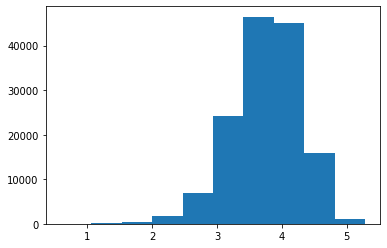

In [ ]:
#### don't put in submission
#compare predictions to actual w/ plots
import matplotlib.pyplot as plt
print(combined_pred_df['prediction'].mean())
print(combined_pred_df['prediction'].std())
plt.hist(combined_pred_df['prediction'])
plt.show() ####################################### need to better predict 1's, 2's and 5's

In [ ]:
#load in yelp_val to see the true star ratings
reviews_validation2 = sc.textFile('/content/drive/MyDrive/data/yelp_val.csv')

reviews_validation2 = reviews_validation2.mapPartitions(lambda x: csv.reader(x))
header_reviews_validation2 = reviews_validation2.first() #remove headers
reviews_validation2 = reviews_validation2.filter(lambda x: x != header_reviews_validation2)
reviews_validation2_final = reviews_validation2.map(lambda x: (x[0], x[1], float(x[2]))) #business id, (user id, score) -- need like this to join to business_json first

reviews_val_df = pd.DataFrame(reviews_validation2_final.collect(), columns=['user_id','business_id','stars'])

3.750499845118414
1.122157025449007


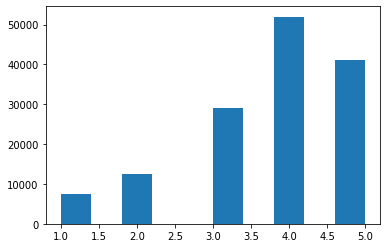

In [ ]:
print(reviews_val_df['stars'].mean())
print(reviews_val_df['stars'].std())
plt.hist(reviews_val_df['stars'])
plt.show()

In [ ]:
#USE ALL RATINGS, NOT CO-RATINGS
def itemCF(review_data):
  #set reused values
    input_user = review_data[1]
    input_business = review_data[0]
    #return_input = (map_back_users[input_user], map_back_business[input_business])
    return_input = (input_user, input_business)

    pearsonweight_and_originalscore = list() #store the Pearson weight (w_i,n) and corresponding original score (r_u,n)
    #pearsonweight_dict = dict() #keep track of which matched businesses have been calculated

    #cover special cases first
    #if the user has no history, use the average score from all users
    user_history = user_rated_scores_dict.get(input_user, 'NA')
    if user_history == 'NA':
      return tuple(list(return_input) + [global_user_average])
    user_average = np.mean([user_score[1] for user_score in user_history])

    #if the business has no ratings, use the average score from the input user
    business_history_self = self_business_scores_dict.get(input_business, 'NA')
    if business_history_self == 'NA':
      return tuple(list(return_input) + [user_average])

    else:
      #calculate centered (original-avg) score for users in a business
      business_average = np.mean([*business_history_self.values()]) #get the mean of the input test data business from all the users
      business_history_centered = {user_id: (float(business_history_self.get(user_id)) - business_average) for user_id in business_history_self}

  #go through each business rated by the user
    for rated_business in user_history:
      rated_business_id = rated_business[0]
      rated_business_score = rated_business[1]

      #get the original and centered scores for the rated business
      near_business_self = self_business_scores_dict.get(rated_business_id)
      near_business_avg = np.mean([*near_business_self.values()])
      near_business_centered = {user_id: (float(near_business_self.get(user_id)) - near_business_avg) for user_id in near_business_self}

      #get the users who rated both businesses
      #co_users = set(list(business_history_centered.keys())).intersection(set(list(near_business_centered.keys())))
      co_users = business_history_centered.keys() & near_business_centered.keys()
      if not co_users: #len(co_users) == 0: #if no user both rated the same businesses, use the average score from the input business
        return tuple(list(return_input) + [np.mean([user_average,business_average])])

      #match = (rated_business_id, input_business)
      #if tuple(sorted(match)) not in pearsonweight_dict: #compute Pearson Correlation weights if it has not been computed already for the matching pair
      pearsonweight_numerator = list() #(r_u,i-r_ibar)(r_u,j-r_jbar)
      business_history_denominator = list() #sqrt((r_u,i-r_ibar)^2))
      near_business_denominator = list() #sqrt((r_u,j-r_jbar)^2)
      for user in co_users: #get the weight for each co-user
        pearsonweight_numerator = pearsonweight_numerator + [business_history_centered.get(user)*near_business_centered.get(user)]
        business_history_denominator = business_history_denominator + [business_history_centered.get(user)**2]
        near_business_denominator = near_business_denominator + [near_business_centered.get(user)**2]

      if (math.sqrt(sum(business_history_denominator)))*(math.sqrt(sum(near_business_denominator))) != 0:
        pearson_weight = sum(pearsonweight_numerator) / (math.sqrt(sum(business_history_denominator))*math.sqrt(sum(near_business_denominator)))
        pearsonweight_and_originalscore = pearsonweight_and_originalscore + [(pearson_weight,rated_business_score)]
        #pearsonweight_dict[match] = pearson_weight

      else: #if the denominator of the weight is 0, no need to compute the weight at all
        pearsonweight_and_originalscore = pearsonweight_and_originalscore + [(0,rated_business_score)]
        #pearsonweight_dict[match] = 0
        #continue

    #sort the weights and keep the highest 7 (|N|=7)
    pearsonweight_and_originalscore.sort(reverse=True, key=lambda x: x[0]) #descending order
    #most_similar_businesses = pearsonweight_and_originalscore[:7]

    pearsonsimilarity_numerator = list() #(r_u,n*w_i,n)
    pearsonsimilarity_denominator = list() #|w_i,n|
    for business in pearsonweight_and_originalscore[:7]:
      pearsonsimilarity_numerator = pearsonsimilarity_numerator + [business[0]*business[1]]
      pearsonsimilarity_denominator = pearsonsimilarity_denominator + [math.fabs(business[0])]
    
    if sum(pearsonsimilarity_denominator) != 0:
      pearson_similarity = sum(pearsonsimilarity_numerator)/sum(pearsonsimilarity_denominator)
    else: #for safety, if Pearson similarity denominator is 0, then use the average score from the input business
      return tuple(list(return_input) + [np.mean([user_average,business_average])])

    #if pearson_similarity <= 0: #do not want <=0 scores, so set to the average score from the input business
      #print(return_input)
      #return tuple(list(return_input) + [business_average])
      ##return tuple(list(return_input) + [np.mean([user_average,business_average])]) #experiment with this maybe

    return tuple(list(return_input) + [pearson_similarity])



In [ ]:
#IF WANT TO USE CHECKIN DATA
#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], len(x['elite'].split(',')))))
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']

#join selected features to train data
#reviews_train_final: business id, (user id, score)

#business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score

#join selected features to train data
#reviews_train_final: business id, (user id, score)
train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][1], x[1][0][6])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin


train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][1], x[1][1][2]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful', 'checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

In [ ]:
#IF WANT TO USE CHECKIN DATA AND ELITE

#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], x['elite'].count(',')+1))) #x['elite'].count(',')+1, x['friends'].count(',')+1
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']


train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][1], x[1][0][7])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin


train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','elite','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','elite', 'checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

In [ ]:
#IF WANT TO USE CHECKIN DATA AND ELITE AND FRIENDS

#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], x['elite'].count(',')+1,x['friends'].count(',')+1 ))) #x['elite'].count(',')+1, x['friends'].count(',')+1
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']


train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][1], x[1][0][8])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin

train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','elite','friends','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df['friends'].fillna(value=train_feat_df['friends'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','elite','friends','checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df['friends'].fillna(value=validation_feat_df['friends'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

,business_id,user_id,business_stars,business_review_count,user_average_stars,user_review_count,useful,elite,friends,checkin
17153,-ErwgUmZ1-jHW_rSu55jlg,---1lKK3aKOuomHnwAkAow,4.0,32,3.96,252,67,4,14.767967,141.0
74561,1JgaRBX0oiRsvEhHF3ZMjw,---1lKK3aKOuomHnwAkAow,4.0,59,3.96,252,67,4,14.767967,151.0
11787,DXlDzOcpdUE_F21tok0fgw,---1lKK3aKOuomHnwAkAow,4.0,1830,3.96,252,67,4,14.767967,3252.0
1966,Ks0M3J4vZAKsHPuCINz5fQ,---1lKK3aKOuomHnwAkAow,3.5,296,3.96,252,67,4,14.767967,884.0
31464,N8Rwk4XrKaHYXXninuxg9Q,---1lKK3aKOuomHnwAkAow,5.0,66,3.96,252,67,4,14.767967,40.0


In [ ]:
#IF WANT TO USE CHECKIN DATA AND ELITE AND FRIENDS AND YELPING SINCE

#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], x['elite'].count(',')+1,x['friends'].count(',')+1, (datetime.strptime('2022-01-01','%Y-%m-%d') - datetime.strptime(x['yelping_since'],'%Y-%m-%d')).days/365.25 ))) #x['elite'].count(',')+1, x['friends'].count(',')+1
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']


train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][1], x[1][0][9])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin

train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','elite','friends','yelping_since','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df['friends'].fillna(value=train_feat_df['friends'].mean(), inplace=True)
train_feat_df['yelping_since'].fillna(value=train_feat_df['yelping_since'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count','useful','elite','friends','yelping_since','checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df['friends'].fillna(value=validation_feat_df['friends'].mean(), inplace=True)
validation_feat_df['yelping_since'].fillna(value=validation_feat_df['yelping_since'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

,business_id,user_id,business_stars,business_review_count,user_average_stars,user_review_count,useful,elite,friends,yelping_since,checkin
17153,-ErwgUmZ1-jHW_rSu55jlg,---1lKK3aKOuomHnwAkAow,4.0,32,3.96,252,67,4,811,14.579055,141.0
74561,1JgaRBX0oiRsvEhHF3ZMjw,---1lKK3aKOuomHnwAkAow,4.0,59,3.96,252,67,4,811,14.579055,151.0
11787,DXlDzOcpdUE_F21tok0fgw,---1lKK3aKOuomHnwAkAow,4.0,1830,3.96,252,67,4,811,14.579055,3252.0
1966,Ks0M3J4vZAKsHPuCINz5fQ,---1lKK3aKOuomHnwAkAow,3.5,296,3.96,252,67,4,811,14.579055,884.0
31464,N8Rwk4XrKaHYXXninuxg9Q,---1lKK3aKOuomHnwAkAow,5.0,66,3.96,252,67,4,811,14.579055,40.0


In [ ]:
#IF WANT TO USE CHECKIN DATA AND ELITE AND FRIENDS AND YELPING SINCE AND COMPLIMENT_FUNNY

#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], 
    x['elite'].count(',')+1,x['friends'].count(',')+1, (datetime.strptime('2022-01-01','%Y-%m-%d') - datetime.strptime(x['yelping_since'],'%Y-%m-%d')).days/365.25, x['compliment_funny'] ))) #x['elite'].count(',')+1, x['friends'].count(',')+1
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']


train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][1][6], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][0][9], x[1][1], x[1][0][10])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin

train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count',
                                                    'useful','elite','friends','yelping_since','compliment_funny','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df['friends'].fillna(value=train_feat_df['friends'].mean(), inplace=True)
train_feat_df['yelping_since'].fillna(value=train_feat_df['yelping_since'].mean(), inplace=True)
train_feat_df['compliment_funny'].fillna(value=train_feat_df['compliment_funny'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][1][6]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][0][9], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','user_average_stars','user_review_count',
                                                              'useful','elite','friends','yelping_since','compliment_funny','checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df['friends'].fillna(value=validation_feat_df['friends'].mean(), inplace=True)
validation_feat_df['yelping_since'].fillna(value=validation_feat_df['yelping_since'].mean(), inplace=True)
validation_feat_df['compliment_funny'].fillna(value=validation_feat_df['compliment_funny'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

,business_id,user_id,business_stars,business_review_count,user_average_stars,user_review_count,useful,elite,friends,yelping_since,compliment_funny,checkin
17153,-ErwgUmZ1-jHW_rSu55jlg,---1lKK3aKOuomHnwAkAow,4.0,32,3.96,252,67,4,811,14.579055,16,141.0
74561,1JgaRBX0oiRsvEhHF3ZMjw,---1lKK3aKOuomHnwAkAow,4.0,59,3.96,252,67,4,811,14.579055,16,151.0
11787,DXlDzOcpdUE_F21tok0fgw,---1lKK3aKOuomHnwAkAow,4.0,1830,3.96,252,67,4,811,14.579055,16,3252.0
1966,Ks0M3J4vZAKsHPuCINz5fQ,---1lKK3aKOuomHnwAkAow,3.5,296,3.96,252,67,4,811,14.579055,16,884.0
31464,N8Rwk4XrKaHYXXninuxg9Q,---1lKK3aKOuomHnwAkAow,5.0,66,3.96,252,67,4,811,14.579055,16,40.0


In [ ]:
#IF WANT TO USE CHECKIN DATA AND ELITE AND FRIENDS AND YELPING SINCE AND COMPLIMENT_FUNNY AND IS_OPEN BUSINESS

#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"], x['is_open'])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], 
    x['elite'].count('20'), x['friends'].count('20')+1, (datetime.strptime('2022-01-01','%Y-%m-%d') - datetime.strptime(x['yelping_since'],'%Y-%m-%d')).days/365.25, x['compliment_funny'] ))) #x['elite'].count(',')+1, x['friends'].count(',')+1
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
##min year=2004, max year=2018, so using '20' is fine and won't double count 2020

train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1],x[1][1][2]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][0][4], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][1][6], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][0][9], x[1][0][10], x[1][1], x[1][0][11])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin

train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','business_is_open','user_average_stars','user_review_count',
                                                    'useful','elite','friends','yelping_since','compliment_funny','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['business_is_open'].fillna(value=train_feat_df['business_is_open'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df['friends'].fillna(value=train_feat_df['friends'].mean(), inplace=True)
train_feat_df['yelping_since'].fillna(value=train_feat_df['yelping_since'].mean(), inplace=True)
train_feat_df['compliment_funny'].fillna(value=train_feat_df['compliment_funny'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1],x[1][1][2]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][1][6]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][0][9], x[1][0][10], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','business_is_open','user_average_stars','user_review_count',
                                                              'useful','elite','friends','yelping_since','compliment_funny','checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['business_is_open'].fillna(value=validation_feat_df['business_is_open'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df['friends'].fillna(value=validation_feat_df['friends'].mean(), inplace=True)
validation_feat_df['yelping_since'].fillna(value=validation_feat_df['yelping_since'].mean(), inplace=True)
validation_feat_df['compliment_funny'].fillna(value=validation_feat_df['compliment_funny'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

,business_id,user_id,business_stars,business_review_count,business_is_open,user_average_stars,user_review_count,useful,elite,friends,yelping_since,compliment_funny,checkin
17153,-ErwgUmZ1-jHW_rSu55jlg,---1lKK3aKOuomHnwAkAow,4.0,32,0,3.96,252,67,4,4,14.579055,9,141.0
74561,1JgaRBX0oiRsvEhHF3ZMjw,---1lKK3aKOuomHnwAkAow,4.0,59,0,3.96,252,67,4,4,14.579055,9,151.0
11787,DXlDzOcpdUE_F21tok0fgw,---1lKK3aKOuomHnwAkAow,4.0,1830,1,3.96,252,67,4,4,14.579055,9,3252.0
1966,Ks0M3J4vZAKsHPuCINz5fQ,---1lKK3aKOuomHnwAkAow,3.5,296,1,3.96,252,67,4,4,14.579055,9,884.0
31464,N8Rwk4XrKaHYXXninuxg9Q,---1lKK3aKOuomHnwAkAow,5.0,66,1,3.96,252,67,4,4,14.579055,9,40.0


In [15]:
##################################test
#get features from business (stars and review count) and user (average stars and review count)
business_json_feat = business_json.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], (x["stars"], x["review_count"], x['is_open'])))
#business_json_feat = business_json.map(lambda x: (x["business_id"], (x["stars"], x["review_count"])))
user_json_feat = user_json.filter(lambda x: x["user_id"] in map_users).map(lambda x: (x["user_id"], (x["average_stars"], x["review_count"], x['useful'], 
    x['elite'].count('20'), x['friends'].count('20')+1, (datetime.strptime('2022-01-01','%Y-%m-%d') - datetime.strptime(x['yelping_since'],'%Y-%m-%d')).days/365.25, x['compliment_funny'], x['fans'] ))) #x['elite'].count(',')+1, x['friends'].count(',')+1
#checkin_feat = checkin.map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
checkin_feat = checkin.filter(lambda x: x["business_id"] in map_business).map(lambda x: (x["business_id"], sum(list(x["time"].values())))) # x['fans']
##min year=2004, max year=2018, so using '20' is fine and won't double count 2020

train_feat = reviews_train_final.leftOuterJoin(business_json_feat) # business id, (user id, score), (stars, review_count)  #leftOuterJoin the same count
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0],x[1][0][1],x[1][1][0],x[1][1][1],x[1][1][2]))) #user id, (business_id, score), (stars, review_count) #swap user id to be the key with business id
train_feat = train_feat.leftOuterJoin(user_json_feat) #user id, (business_id, score, business: stars, review_count), (users: average_stars, review_count, useful)
train_feat = train_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][2], x[1][0][3], x[1][0][4], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][1][6], x[1][1][7], x[1][0][1]))) #x[1][1][3]
#train_feat = train_feat.collect() #business id, (user id, business: stars, review_count, users: average_stars, review_count, useful, score)
train_feat = train_feat.leftOuterJoin(checkin_feat)
train_feat = train_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][0][9], x[1][0][10], x[1][0][11], x[1][1], x[1][0][12])) #x[1][1][3]
train_feat = train_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, score, checkin

train_feat_df = pd.DataFrame(train_feat, columns = ['business_id','user_id','business_stars','business_review_count','business_is_open','user_average_stars','user_review_count',
                                                    'useful','elite','friends','yelping_since','compliment_funny','fans','checkin','score'])

#if a row has missing values, replace with the mean of the column
train_feat_df['business_stars'].fillna(value=train_feat_df['business_stars'].mean(), inplace=True)
train_feat_df['business_review_count'].fillna(value=train_feat_df['business_review_count'].mean(), inplace=True)
train_feat_df['business_is_open'].fillna(value=train_feat_df['business_is_open'].mean(), inplace=True)
train_feat_df['user_average_stars'].fillna(value=train_feat_df['user_average_stars'].mean(), inplace=True)
train_feat_df['user_review_count'].fillna(value=train_feat_df['user_review_count'].mean(), inplace=True)
train_feat_df['useful'].fillna(value=train_feat_df['useful'].mean(), inplace=True)
train_feat_df['elite'].fillna(value=train_feat_df['elite'].mean(), inplace=True)
train_feat_df['friends'].fillna(value=train_feat_df['friends'].mean(), inplace=True)
train_feat_df['yelping_since'].fillna(value=train_feat_df['yelping_since'].mean(), inplace=True)
train_feat_df['compliment_funny'].fillna(value=train_feat_df['compliment_funny'].mean(), inplace=True)
train_feat_df['fans'].fillna(value=train_feat_df['fans'].mean(), inplace=True)
train_feat_df['checkin'].fillna(value=train_feat_df['checkin'].mean(), inplace=True)
train_feat_df.head()


#join selected features to validation data
#reviews_train_final: business id, user id
validation_feat = reviews_validation_final.leftOuterJoin(business_json_feat) # business id, (user id, (stars, review_count))  #leftOuterJoin the same count
validation_feat = validation_feat.map(lambda x: (x[1][0], (x[0],x[1][1][0],x[1][1][1],x[1][1][2]))) # user id, (business id, stars, review_count)  ######leftOuterJoin the same count
validation_feat = validation_feat.leftOuterJoin(user_json_feat) #user id, (business_id, business: stars, review_count), (users: average_stars, review_count, useful)
validation_feat = validation_feat.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][1][0], x[1][1][1], x[1][1][2], x[1][1][3], x[1][1][4], x[1][1][5], x[1][1][6], x[1][1][7]))) #x[1][1][3]
validation_feat = validation_feat.leftOuterJoin(checkin_feat)
validation_feat = validation_feat.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][0][5], x[1][0][6], x[1][0][7], x[1][0][8], x[1][0][9], x[1][0][10], x[1][0][11], x[1][1])) #x[1][1][3]
validation_feat = validation_feat.collect() #business id, user id, business: stars, review_count, users: average_stars, review_count, useful, checkin

validation_feat_df = pd.DataFrame(validation_feat, columns = ['business_id','user_id','business_stars','business_review_count','business_is_open','user_average_stars','user_review_count',
                                                              'useful','elite','friends','yelping_since','compliment_funny','fans','checkin'])
#bring back the actual id names
#validation_feat_df['user_id'] = validation_feat_df['user_id'].map(map_back_users)
#validation_feat_df['business_id'] = validation_feat_df['business_id'].map(map_back_business)
validation_feat_df = validation_feat_df.sort_values(['user_id','business_id'])

#if a row has missing values, replace with the mean of the column
validation_feat_df['business_stars'].fillna(value=validation_feat_df['business_stars'].mean(), inplace=True)
validation_feat_df['business_review_count'].fillna(value=validation_feat_df['business_review_count'].mean(), inplace=True)
validation_feat_df['business_is_open'].fillna(value=validation_feat_df['business_is_open'].mean(), inplace=True)
validation_feat_df['user_average_stars'].fillna(value=validation_feat_df['user_average_stars'].mean(), inplace=True)
validation_feat_df['user_review_count'].fillna(value=validation_feat_df['user_review_count'].mean(), inplace=True)
validation_feat_df['useful'].fillna(value=validation_feat_df['useful'].mean(), inplace=True)
validation_feat_df['elite'].fillna(value=validation_feat_df['elite'].mean(), inplace=True)
validation_feat_df['friends'].fillna(value=validation_feat_df['friends'].mean(), inplace=True)
validation_feat_df['yelping_since'].fillna(value=validation_feat_df['yelping_since'].mean(), inplace=True)
validation_feat_df['compliment_funny'].fillna(value=validation_feat_df['compliment_funny'].mean(), inplace=True)
validation_feat_df['fans'].fillna(value=validation_feat_df['fans'].mean(), inplace=True)
validation_feat_df['checkin'].fillna(value=validation_feat_df['checkin'].mean(), inplace=True)
validation_feat_df.head()

,business_id,user_id,business_stars,business_review_count,business_is_open,user_average_stars,user_review_count,useful,elite,friends,yelping_since,compliment_funny,fans,checkin
17153,-ErwgUmZ1-jHW_rSu55jlg,---1lKK3aKOuomHnwAkAow,4.0,32,0,3.96,252,67,4,4,14.579055,9,16,141.0
74561,1JgaRBX0oiRsvEhHF3ZMjw,---1lKK3aKOuomHnwAkAow,4.0,59,0,3.96,252,67,4,4,14.579055,9,16,151.0
11787,DXlDzOcpdUE_F21tok0fgw,---1lKK3aKOuomHnwAkAow,4.0,1830,1,3.96,252,67,4,4,14.579055,9,16,3252.0
1966,Ks0M3J4vZAKsHPuCINz5fQ,---1lKK3aKOuomHnwAkAow,3.5,296,1,3.96,252,67,4,4,14.579055,9,16,884.0
31464,N8Rwk4XrKaHYXXninuxg9Q,---1lKK3aKOuomHnwAkAow,5.0,66,1,3.96,252,67,4,4,14.579055,9,16,40.0


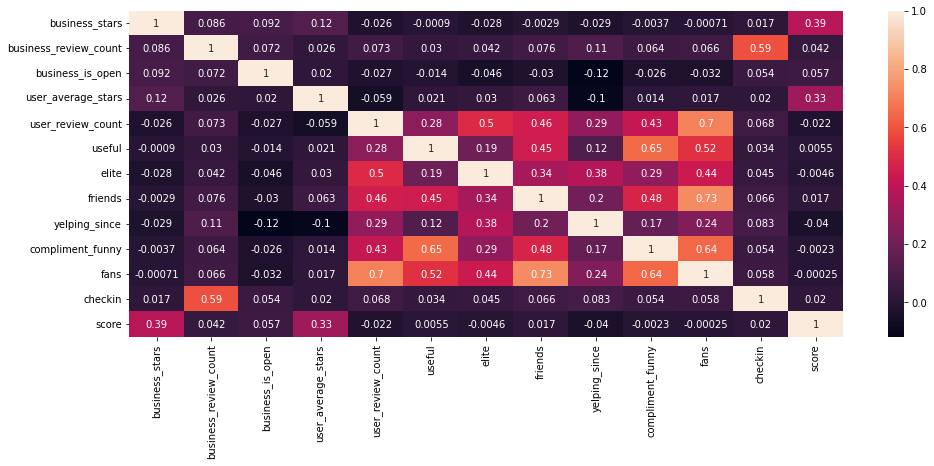

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
corr = train_feat_df.corr()
sns.heatmap(corr, annot=True)